In [1]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', "NaN"]

data = pd.read_csv("./data/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["Z"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["Z"] = df["Z"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


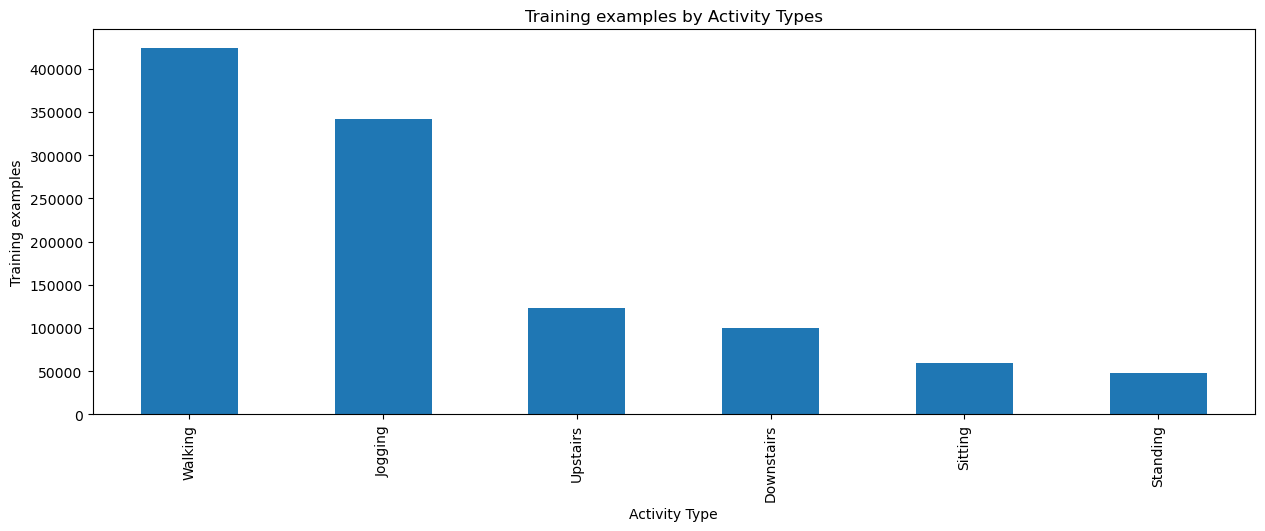

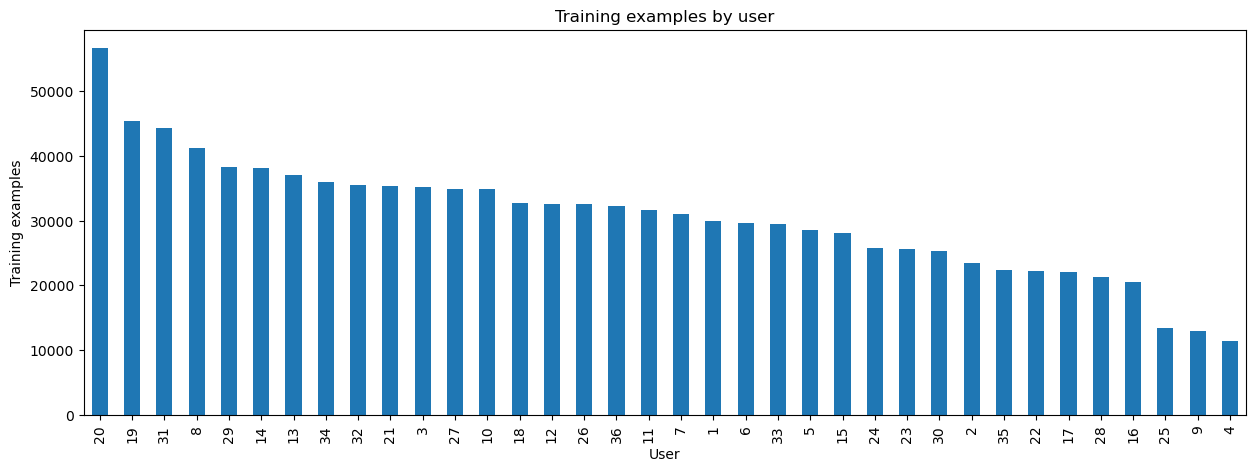

In [3]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

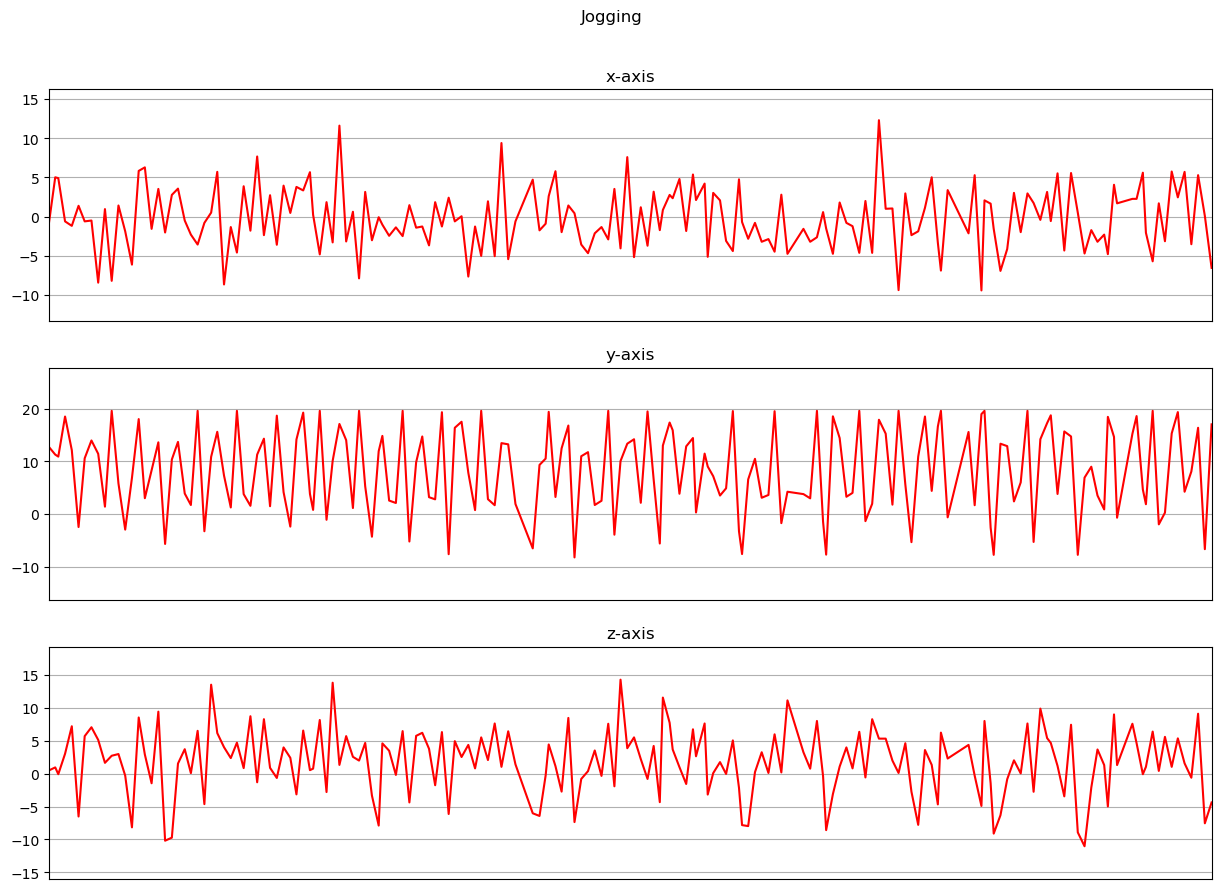

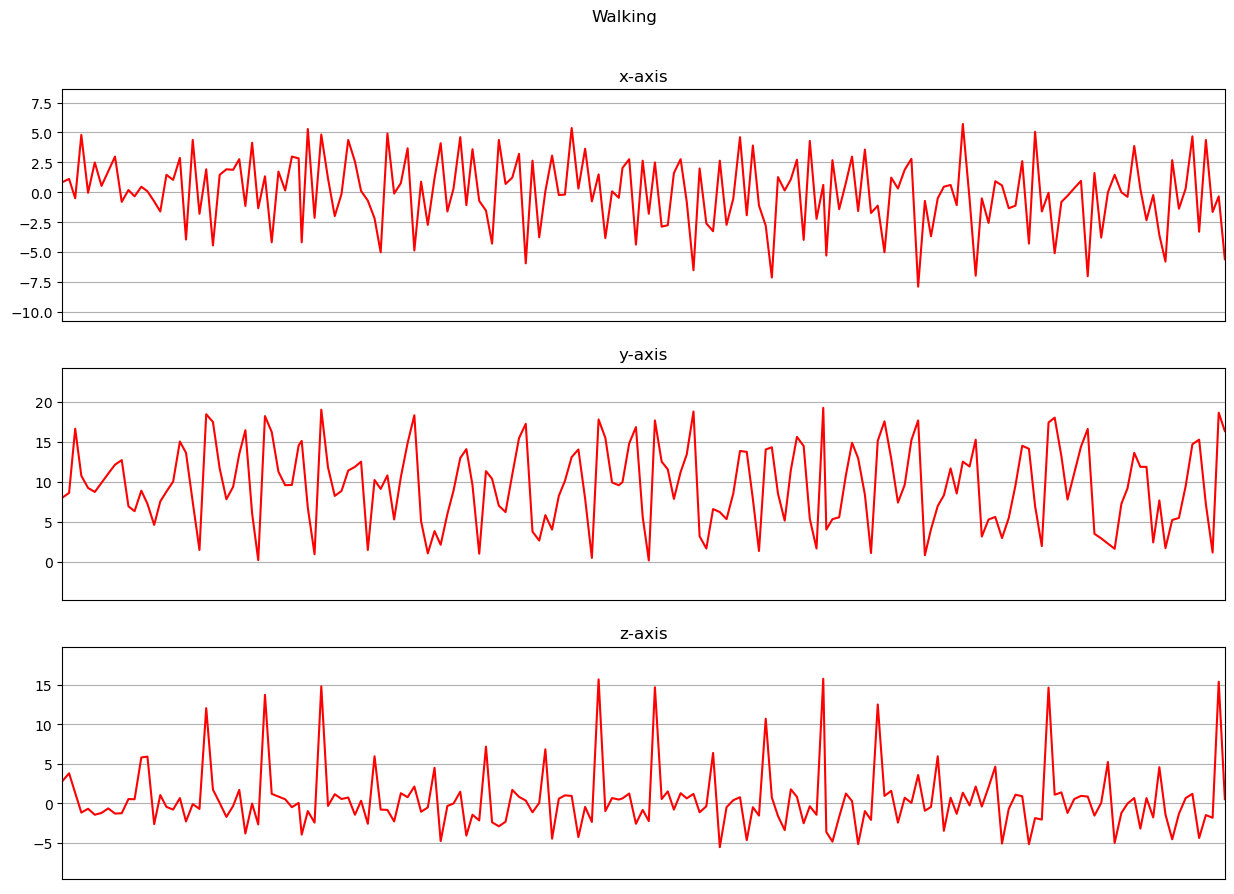

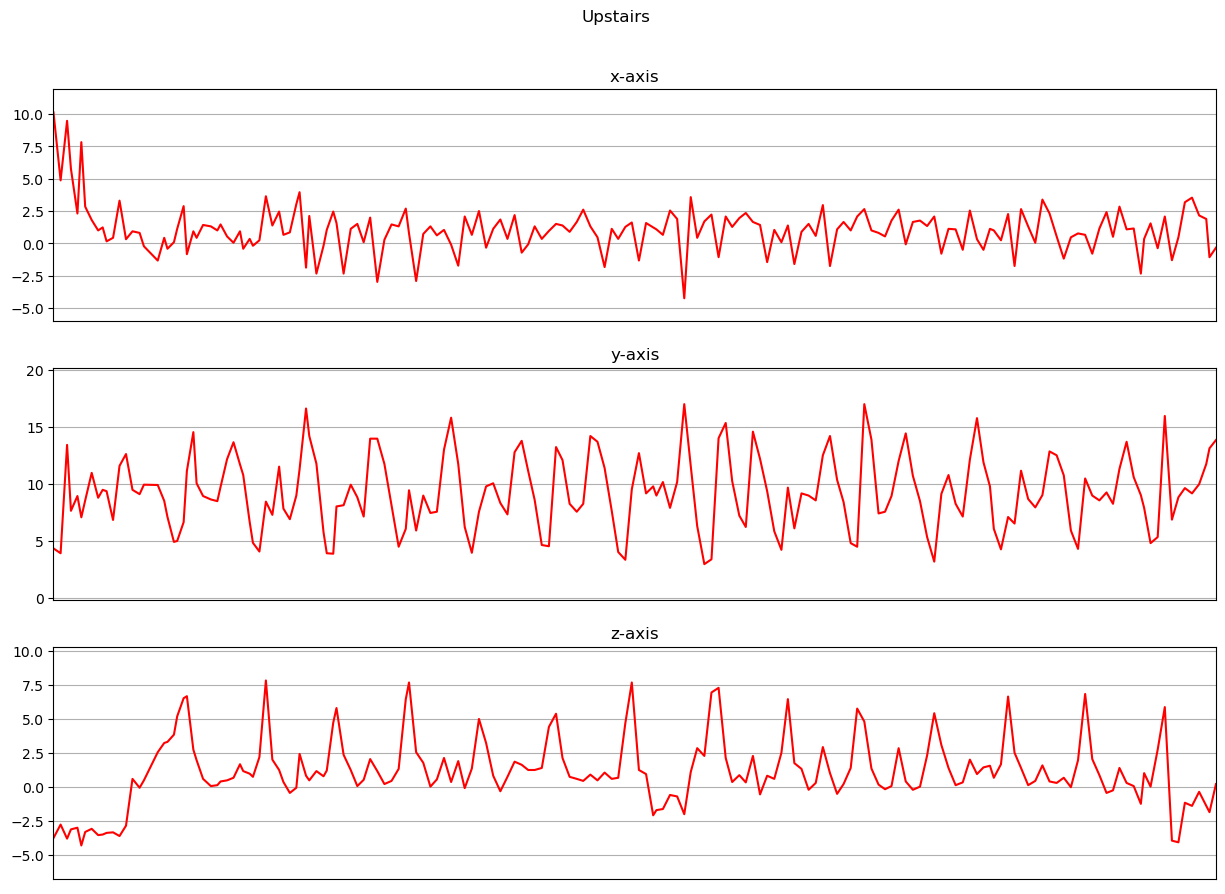

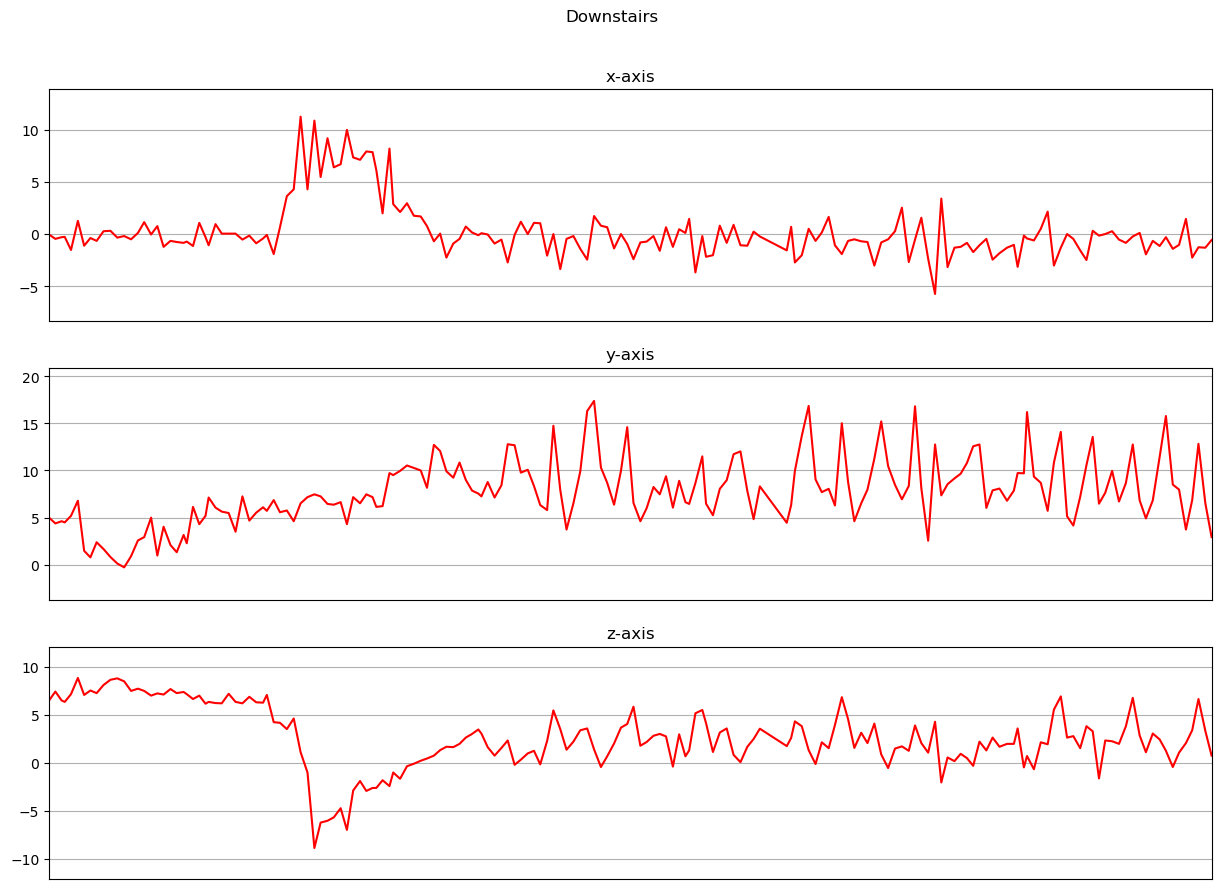

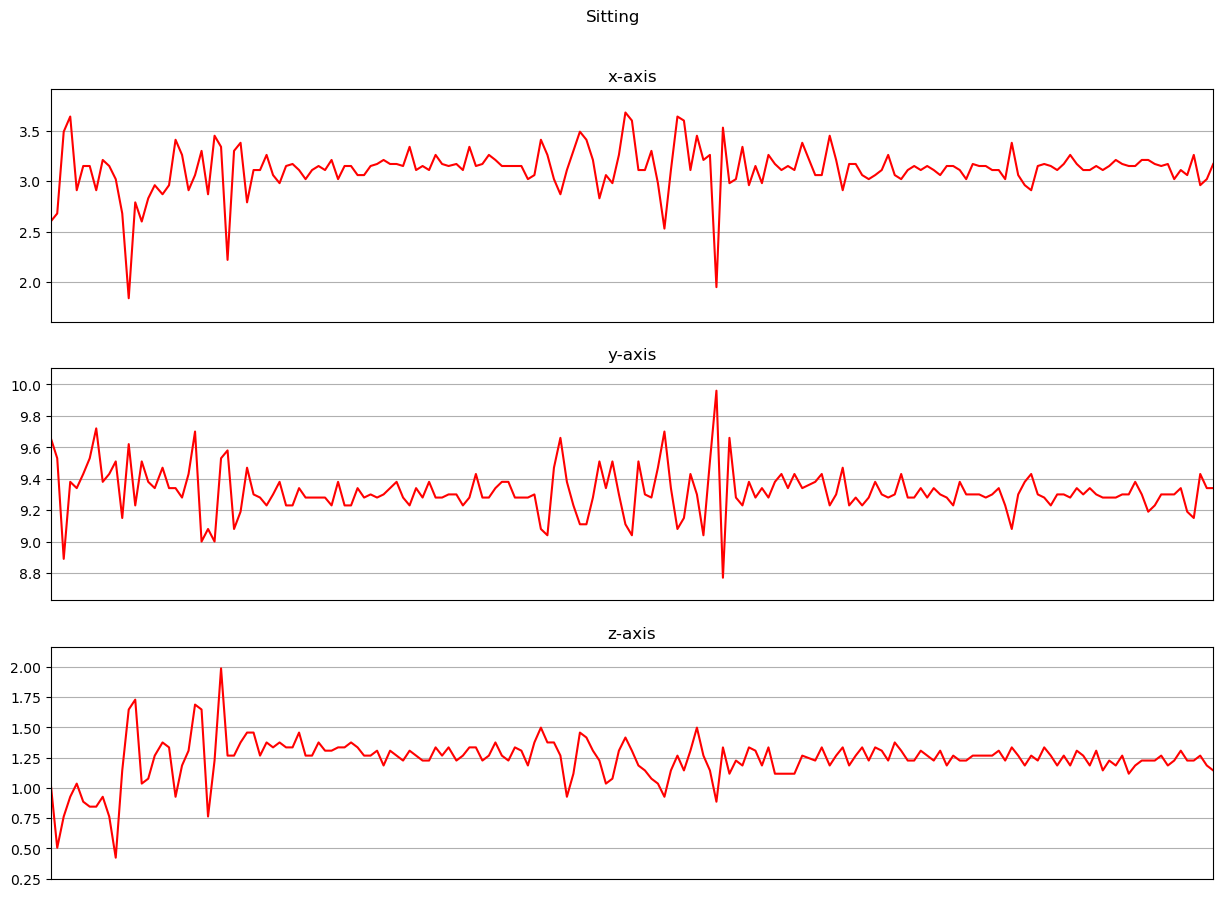

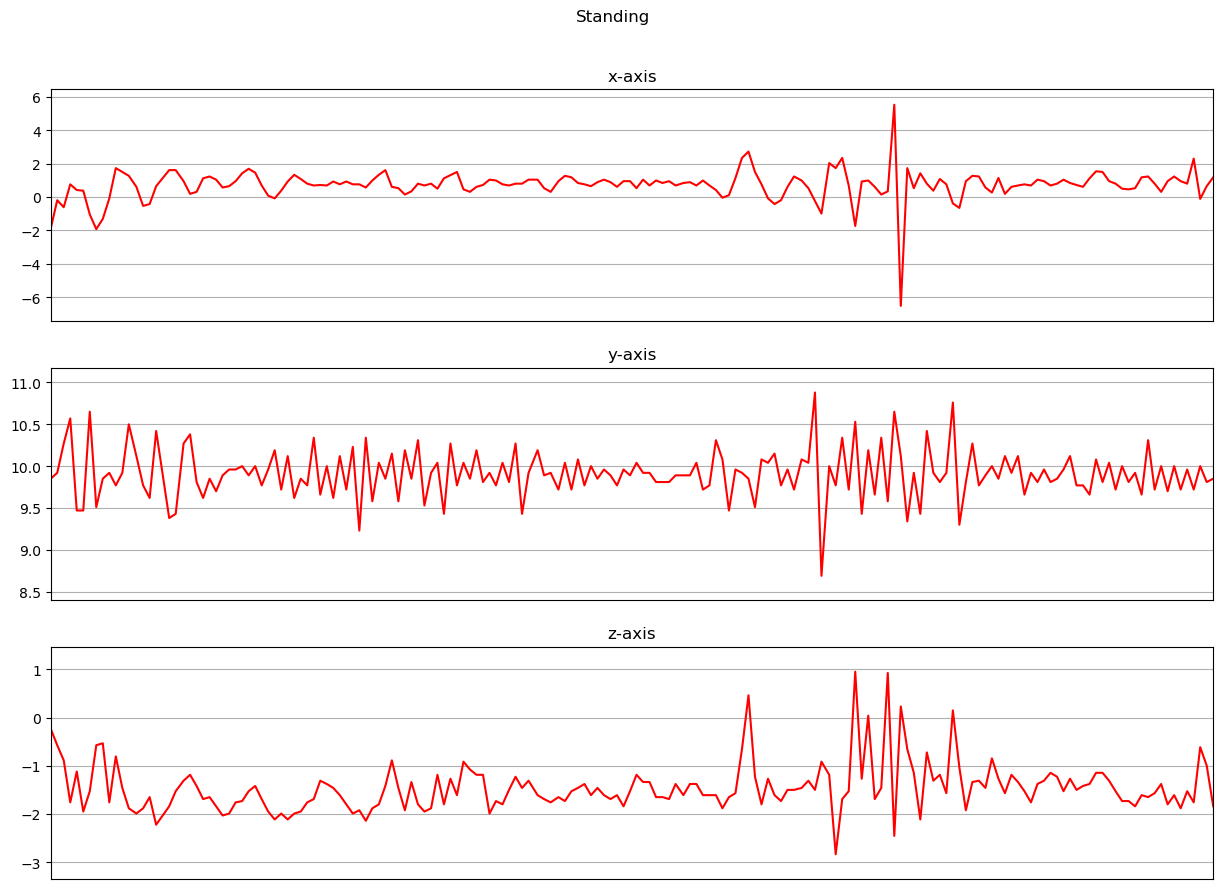

In [4]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [5]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [6]:
df = df.drop('activity', axis=1)
df

,user-id,timestamp,X,Y,Z,activityEncode
0,33,49105962326000,-0.694638,12.680544,0.503953,1
1,33,49106062271000,5.012288,11.264028,0.953424,1
2,33,49106112167000,4.903325,10.882658,-0.081722,1
3,33,49106222305000,-0.612916,18.496431,3.023717,1
4,33,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...
1098199,19,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,131623491487000,9.000000,-1.460000,1.730000,2


In [7]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

# Data Split

In [8]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

# Normalization

In [9]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,timestamp,X,Y,Z,activityEncode
8489,17,57869902574000,0.510163,0.741908,0.488932,5
8490,17,57870012316000,0.495703,0.751526,0.487895,5
8491,17,57870122301000,0.489850,0.742938,0.484785,5
8492,17,57870222246000,0.499490,0.748778,0.489623,5
8493,17,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...
1098199,19,131623331483000,0.723205,0.454981,0.545293,2
1098200,19,131623371431000,0.724216,0.457755,0.546308,2
1098201,19,131623411592000,0.725228,0.459773,0.545293,2
1098202,19,131623491487000,0.723205,0.457755,0.546308,2


In [10]:
df_train.shape

(813422, 6)

In [11]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((878562, 5), (219641, 5), (878562,), (219641,))

In [13]:
# Create train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=  y_train)

In [14]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [15]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

y_val_array = np.array(y_val)
val_set = np.c_[X_val, y_val_array]

X_train, y_train = split_sequences(train_set, 80)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 80)
print(X_test.shape, y_test.shape)

X_val, y_val = split_sequences(val_set, 80)
print(X_val.shape, y_val.shape)

(658842, 80, 5) (658842,)
(219562, 80, 5) (219562,)
(219562, 80, 5) (219562,)


In [16]:
# Convert output variables to categorical for CNN
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

y_val = to_categorical(y_val)
print(y_val.shape)

(658842, 6)
(219562, 6)
(219562, 6)


In [17]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

80 5 6


# LSTM Model

In [18]:
model = Sequential()
model.add(LSTM(50, input_shape = [n_timesteps, n_features]))
model.add(Dropout(rate = 0.5))
model.add(Dense(50, activation = "relu"))
model.add(Dense(n_outputs, activation = "softmax"))

In [19]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 6)                 306       
                                                                 
Total params: 14,056
Trainable params: 14,056
Non-trainable params: 0
_________________________________________________________________


In [ ]:
validation_split = 0.2
history = model.fit(X_train, y_train, batch_size= 64, epochs=10, verbose=True,  validation_split=validation_split)

Epoch 1/10
8236/8236 [==============================] - 310s 37ms/step - loss: 1.4867 - accuracy: 0.3951 - val_loss: 1.4889 - val_accuracy: 0.3960
Epoch 2/10
8236/8236 [==============================] - 305s 37ms/step - loss: 1.4825 - accuracy: 0.3975 - val_loss: 1.4871 - val_accuracy: 0.3960
Epoch 3/10
8236/8236 [==============================] - 297s 36ms/step - loss: 1.4818 - accuracy: 0.3975 - val_loss: 1.4823 - val_accuracy: 0.3960
Epoch 4/10
8236/8236 [==============================] - 348s 42ms/step - loss: 1.4814 - accuracy: 0.3975 - val_loss: 1.4799 - val_accuracy: 0.3960
Epoch 5/10
5102/8236 [=================>............] - ETA: 1:55 - loss: 1.4809 - accuracy: 0.3975

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test2 = np.argmax(y_test_hot, axis=-1)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
cm=confusion_matrix(y_test2,y_pred)

print(cm)
print(accuracy_score(y_test2,y_pred))
print(classification_report(y_test2,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')